1. Gerekli kütüphaneler

In [179]:
# 🌟 Veri işleme ve analiz için temel kütüphaneler
import pandas as pd  # Veri okuma, işleme ve DataFrame oluşturma işlemleri için
import numpy as np   # Sayısal işlemler, diziler ve matematiksel hesaplamalar için

# 🔧 Veri ölçeklendirme ve değerlendirme metrikleri
from sklearn.preprocessing import StandardScaler  # Verileri ölçeklendirmek (standartlaştırmak) için
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve  # Model performansını değerlendirmek için

# 🚀 Yapay Sinir Ağı (ANN) modelleri için TensorFlow ve Keras bileşenleri
from tensorflow.keras.models import Sequential  # Keras ile sıralı model oluşturmak için
from tensorflow.keras.layers import Dense, Dropout, Input  # Yapay sinir ağı katmanları (yoğun, dropout ve giriş)
from tensorflow.keras.utils import to_categorical  # Kategorik hedef değişkeni one-hot encoding formatına dönüştürmek için
from tensorflow.keras.callbacks import EarlyStopping  # Model eğitimini erken durdurmak için (overfitting'i önlemek amacıyla)

# ⚖️ Sınıf dengesizlik sorununu çözmek için SMOTE yöntemi
from imblearn.over_sampling import SMOTE  # Azınlık sınıfı örneklerini artırmak (dengeleme) için
from collections import Counter  # Sınıf dağılımını saymak ve analiz etmek için

# 📊 Görselleştirme ve analiz grafikleri oluşturmak için
import matplotlib.pyplot as plt  # Grafikler ve görselleştirmeler oluşturmak için
import seaborn as sns  # Estetik görseller ve gelişmiş grafik stilleri için

2. Veriyi okuma

In [180]:
# Verileri oku
train_df = pd.read_csv("../datasets/pca/train_mental_pca.csv")
test_df = pd.read_csv("../datasets/pca/test_mental_pca.csv")

# Özellik ve hedef ayır
X_train = train_df.drop("support_needed", axis=1)
y_train = train_df["support_needed"]

X_test = test_df.drop("support_needed", axis=1)
y_test = test_df["support_needed"]

print("✅ Eğitim verisi:", X_train.shape)
print("✅ Test verisi:", X_test.shape)
print("🎯 Sınıf dağılımı (y_train):\n", pd.Series(y_train).value_counts())

✅ Eğitim verisi: (1007, 19)
✅ Test verisi: (252, 19)
🎯 Sınıf dağılımı (y_train):
 support_needed
0    528
1    479
Name: count, dtype: int64


3. SMOTE ile veri dengeleme

In [181]:
print("🎯 Orijinal sınıf dağılımı:", Counter(y_train))

# 3️⃣ SMOTE ile oversampling
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("⚖️ Dengelenmiş eğitim sınıf dağılımı:", Counter(y_train_balanced))

🎯 Orijinal sınıf dağılımı: Counter({0: 528, 1: 479})
⚖️ Dengelenmiş eğitim sınıf dağılımı: Counter({0: 528, 1: 528})


In [182]:
# 🌟 Eğitim ve test hedeflerini one-hot encode yapma
y_train_cat = to_categorical(y_train_balanced)
y_test_cat = to_categorical(y_test)

4. ANN modeli

In [183]:
model = Sequential([
    Input(shape=(X_train_balanced.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='sigmoid')  # 2 sınıf için sigmoid
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_74 (Dense)                │ (None, 128)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,962 (50.63 KB)

 Trainable params: 12,962 (50.63 KB)

 Non-trainable params: 0 (0.00 B)

5. Model eğitimi

In [184]:
# 🌟 Eğitim sırasında erken durma kriteri
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 🚀 Model eğitimi
history = model.fit(
    X_train_balanced,            # Girdi verisi
    y_train_cat,                 # Hedef verisi
    epochs=30,                   # Maksimum dönem sayısı
    batch_size=32,               # Mini-batch boyutu
    validation_split=0.2,        # Eğitim/Doğrulama oranı
    callbacks=[early_stop],      # Erken durma kriteri
    verbose=1                    # Eğitim ilerlemesini göster
)

print("✅ Model başarıyla eğitildi.")

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5433 - loss: 0.9589 - val_accuracy: 0.7783 - val_loss: 0.4619
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6829 - loss: 0.6145 - val_accuracy: 0.8066 - val_loss: 0.4415
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7425 - loss: 0.5795 - val_accuracy: 0.8113 - val_loss: 0.4216
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7299 - loss: 0.5719 - val_accuracy: 0.8160 - val_loss: 0.4325
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7366 - loss: 0.5748 - val_accuracy: 0.8066 - val_loss: 0.4253
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7450 - loss: 0.5161 - val_accuracy: 0.8160 - val_loss: 0.4233
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7552 - loss: 0.5121 - val_accuracy: 0.8066 - val_loss: 0.4294
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7519 - loss: 0.5591 - val_accuracy: 0.8066 - v

6. Tahmin, rapor ve görselleştirme

In [185]:
# Tahmin (olasılıklar)
y_proba = model.predict(X_test)

# En yüksek olasılığa göre sınıf tahmini
y_pred = y_proba.argmax(axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


📋 PCA Sonrası Sınıflandırma Raporu (ANN):

              precision    recall  f1-score   support

           0      0.805     0.811     0.808       132
           1      0.790     0.783     0.787       120

    accuracy                          0.798       252
   macro avg      0.797     0.797     0.797       252
weighted avg      0.798     0.798     0.798       252



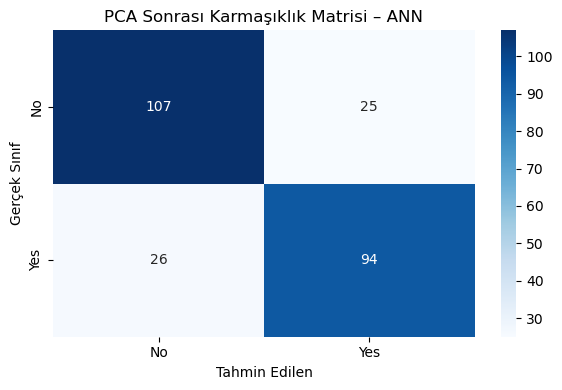

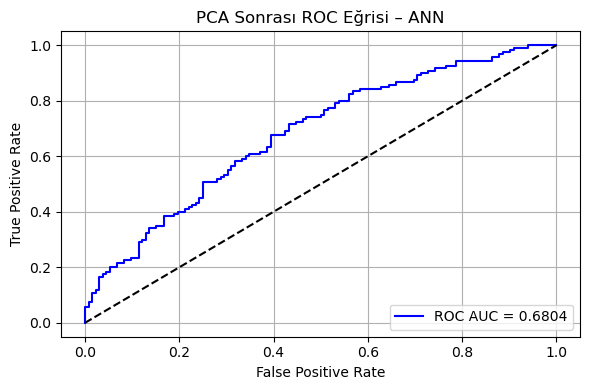

In [188]:
# 📋 Sınıflandırma raporu
print("📋 PCA Sonrası Sınıflandırma Raporu (ANN):\n")
report = classification_report(y_test, y_pred, digits=3)  # 3 basamak hassasiyeti
print(report)

# 🔍 Karmaşıklık Matrisi
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.title("PCA Sonrası Karmaşıklık Matrisi – ANN")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Sınıf")
plt.tight_layout()
plt.show()

# 🌈 ROC Eğrisi
fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
roc_auc = roc_auc_score(y_test, y_proba[:, 1])

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}", color="blue")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("PCA Sonrası ROC Eğrisi – ANN")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

7. Model kaydı

In [187]:
import joblib

model.save("../saved_model/pca/mental_ann_model.keras")
joblib.dump(model, "../saved_model/pca/mental_ann_model.pkl")

print("💾 Model başarıyla kaydedildi:")
print("- mental_ann_model.keras")
print("- mental_ann_model.pkl")

💾 Model başarıyla kaydedildi:
- mental_ann_model.keras
- mental_ann_model.pkl
